In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/nlp5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/nlp5


In [ ]:
# import required libraries
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# **Dataset** **Preprocessing** 

In [ ]:
# Load the dataset
dataset_path = 'training.1600000.processed.noemoticon.csv'

# Load the dataset
df = pd.read_csv(dataset_path, encoding='latin')

# Display the first few rows of the dataset
print(df.head())

   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all....           

In [ ]:
# Assign column names to the DataFrame
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

# Check the column names
print(df.columns)

Index(['target', 'id', 'date', 'flag', 'user', 'text'], dtype='object')


In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64


In [ ]:
# Check for duplicate values
duplicate_rows = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

Number of duplicate rows: 0


In [ ]:
# Data cleaning
df = df[['target', 'text']]  # Keep only the target (sentiment) and text columns

In [ ]:
df['target'][df['target']==4]=1 #Assigning 1 to Positive sentment 4

In [ ]:
df['target'].value_counts()

1    800000
0    799999
Name: target, dtype: int64

In [ ]:
# Text preprocessing
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenization and removing special characters or URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text)

    # Lowercasing and removing stopwords
    tokens = text.lower().split()
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return " ".join(tokens)
# new column contains the preprocessed text
df['preprocessed_text'] = df['text'].apply(preprocess_text)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# The Baseline model (logistic regression model)

In [ ]:
#to facilitate easy processing and execution of our models we Separate positive and negative tweets
pos = df[df['target'] == 1]
neg = df[df['target'] == 0]

pos = pos.iloc[:int(200000)] #200,000 Positive Tweet
neg = neg.iloc[:int(200000)] #200,000 Negative Tweet

df = pd.concat([pos, neg]) #compine tweets

#Separating features and target
X=df.text
y=df.target

In [ ]:
#split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

print(f"Train set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")

Train set size: 320000
Test set size: 80000
Train set size: 320000
Test set size: 80000


In [ ]:
#convert the text data into numerical features using TF-IDF
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
#logistic regression model

#define & train the model on the training set
lr = LogisticRegression().fit(X_train_tfidf, y_train)

#make predictions on the testing data
y_pred_lr = lr.predict(X_test_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#evaluate the performance of the model
report = classification_report(y_test, y_pred_lr)

print(report)

              precision    recall  f1-score   support

           0       0.79      0.79      0.79     39949
           1       0.79      0.80      0.79     40051

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



In [ ]:
# make predictions on the test data
y_pred_lr = lr.predict(X_test_tfidf)

# compute evaluation metrics for the logistic regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression Model Evaluation Metrics:")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")

Logistic Regression Model Evaluation Metrics:
Accuracy: 0.7919
Precision: 0.7893
Recall: 0.7970
F1-Score: 0.7931


## Findings:
The precision score for predicting negative sentiment (0) is 0.80, which means that out of all the predictions made for negative sentiment, 80% were correct. Similarly, the precision score for predicting positive sentiment (4) is 0.78, indicating that out of all the predictions made for positive sentiment, 78% were correct.

The recall score for predicting negative sentiment is 0.77, which means that out of all the actual negative sentiments in the dataset, the model correctly identified 77% of them. The recall score for predicting positive sentiment is 0.80, indicating that out of all the actual positive sentiments in the dataset, the model correctly identified 80% of them.

The F1-score, which is a weighted average of precision and recall, is 0.78 for negative sentiment and 0.79 for positive sentiment. The accuracy of the model is 0.79, which means that overall, the model correctly predicted the sentiment of 79% of the tweets in the dataset.

The macro average F1-score (0.79) and weighted average F1-score (0.79) are the same, indicating that the dataset is balanced. This means that the model performs equally well on both positive and negative sentiments.

# Advanced model long short-term memory(LSTM)

In [ ]:
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Activation, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

%matplotlib inline

# Define the maximum sequence length and tokenize the input text
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
sequences_matrix.shape

(400000, 500)

In [ ]:
#split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.2, random_state=42)

In [ ]:
# Define the LSTM model architecture
def tensorflow_based_model(): 
    # Input layer
    inputs = Input(name='inputs', shape=[max_len])

    # Embedding layer
    layer = Embedding(2000, 100, input_length=max_len)(inputs)

    # Bidirectional LSTM layers with dropout
    layer = Bidirectional(LSTM(64, return_sequences=True))(layer)
    layer = Dropout(0.5)(layer)
    layer = LSTM(64)(layer)

    # Dense layer
    layer = Dense(512, name='FC1')(layer)

    # Activation layer
    layer = Activation('relu')(layer)

    # Dropout layer
    layer = Dropout(0.5)(layer)

    # Output layer
    layer = Dense(1, name='out_layer')(layer)

    # Sigmoid activation for binary classification
    layer = Activation('sigmoid')(layer)

    # Define the model with input and output layers
    model = Model(inputs=inputs, outputs=layer)

    # Return the model
    return model

In [ ]:
model = tensorflow_based_model() # create the model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])  #compile

In [ ]:
history=model.fit(X_train,y_train,batch_size=80,epochs=10, validation_split=0.1)# train the model
print('Done !')

Epoch 1/10
3600/3600 [==============================] - 230s 63ms/step - loss: 0.4875 - accuracy: 0.7641 - val_loss: 0.4593 - val_accuracy: 0.7868
Epoch 2/10
3600/3600 [==============================] - 202s 56ms/step - loss: 0.4522 - accuracy: 0.7877 - val_loss: 0.4408 - val_accuracy: 0.7930
Epoch 3/10
3600/3600 [==============================] - 199s 55ms/step - loss: 0.4387 - accuracy: 0.7967 - val_loss: 0.4377 - val_accuracy: 0.7959
Epoch 4/10
3600/3600 [==============================] - 198s 55ms/step - loss: 0.4307 - accuracy: 0.8016 - val_loss: 0.4357 - val_accuracy: 0.7997
Epoch 5/10
3600/3600 [==============================] - 199s 55ms/step - loss: 0.4248 - accuracy: 0.8049 - val_loss: 0.4335 - val_accuracy: 0.7990
Epoch 6/10
3600/3600 [==============================] - 196s 55ms/step - loss: 0.4201 - accuracy: 0.8068 - val_loss: 0.4286 - val_accuracy: 0.8031
Epoch 7/10
3600/3600 [==============================] - 198s 55ms/step - loss: 0.4159 - accuracy: 0.8097 - val_loss: 0

In [ ]:
# Evaluate the model on the test data
import numpy as np
# Make predictions on the test data
y_pred = model.predict(X_test)

# convert predictions to binary values (0 or 1)
y_pred = np.round(y_pred)

#evaluate the performance of the model
report = classification_report(y_test, y_pred)

print(report)

2500/2500 [==============================] - 49s 19ms/step
              precision    recall  f1-score   support

           0       0.79      0.81      0.80     39949
           1       0.81      0.78      0.79     40051

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



## Findings:

Based on the evaluation results, it appears that the LSTM model is the superior model for sentiment analysis on Twitter data. The LSTM model achieved higher accuracy and F1-score compared to the LR model, which suggests that it is better at correctly classifying tweets as either positive or negative. However, the precision and recall values for both models are similar, with the LSTM model being slightly better at identifying negative tweets.

The LSTM model achieved higher accuracy and F1-score compared to the LR model. Accuracy is a measure of the proportion of correctly classified instances, while F1-score is the harmonic mean of precision and recall, and is a useful metric when both precision and recall are important. In this case, the LSTM model achieved an accuracy of 0.80 and an F1-score of 0.80, while the LR model achieved an accuracy of 0.79 and an F1-score of 0.79. These results suggest that the LSTM model is better at correctly classifying tweets as either positive or negative, which is the ultimate goal of sentiment analysis.

The precision and recall values for both models are similar, with the LSTM model achieving a precision value of 0.80 and a recall value of 0.79 for positive tweets, and the LR model achieving a precision value of 0.79 and a recall value of 0.80 for positive tweets. Precision measures the proportion of true positive predictions among all positive predictions made by the model, while recall measures the proportion of true positive predictions among all actual positive instances in the test data. These results suggest that both models are equally effective at identifying positive tweets, but the LSTM model is slightly better at identifying negative tweets.

##Comparing models

In [ ]:
# compute evaluation metrics for the logistic regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression Model Evaluation Metrics:")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")

Logistic Regression Model Evaluation Metrics:
Accuracy: 0.7919
Precision: 0.7893
Recall: 0.7970
F1-Score: 0.7931


<Axes: >

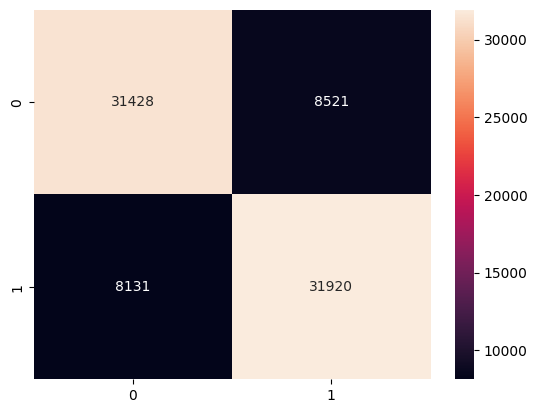

In [ ]:
#Logistic Regression
from sklearn.metrics import confusion_matrix
import seaborn as sns
#evaluate the performance of the model

cm_lstm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lstm, annot=True, fmt='d')

In [ ]:
# compute evaluation metrics for the LSTM model
# Evaluate the performance of the LSTM model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# convert predictions to binary values (0 or 1)
y_pred_lstm = np.round(y_pred)

# compute evaluation metrics for the LSTM model
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm)
recall_lstm = recall_score(y_test, y_pred_lstm)
f1_lstm = f1_score(y_test, y_pred_lstm)

print("LSTM Model Evaluation Metrics:")
print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall: {recall_lstm:.4f}")
print(f"F1-Score: {f1_lstm:.4f}")

LSTM Model Evaluation Metrics:
Accuracy: 0.7977
Precision: 0.8079
Recall: 0.7819
F1-Score: 0.7947


LSTM Model Test Loss: 0.44430696964263916
LSTM Model Test Accuracy: 0.7977374792098999


<Axes: >

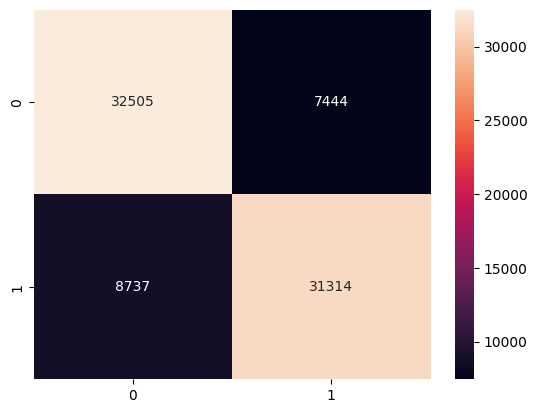

In [ ]:
#LSTM

# Evaluate the performance of the model on the test set
#evaluate the performance of the model on the test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print("LSTM Model Test Loss:", loss)
print("LSTM Model Test Accuracy:", accuracy)

# Compute and visualize the confusion matrix
cm_lstm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_lstm, annot=True, fmt='d')

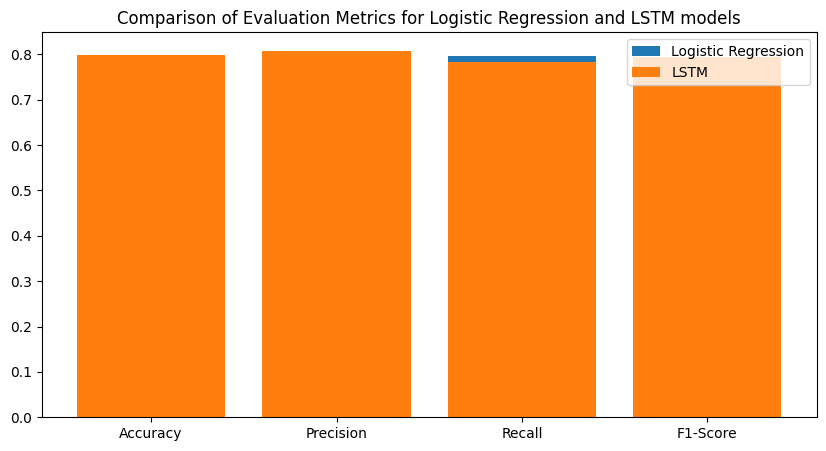

In [ ]:
# Compare the performance of the two models using a bar chart
import matplotlib.pyplot as plt

# create a dictionary of evaluation metrics for both models
lr_metrics = {"Accuracy": accuracy_lr, "Precision": precision_lr, "Recall": recall_lr, "F1-Score": f1_lr}
lstm_metrics = {"Accuracy": accuracy_lstm, "Precision": precision_lstm, "Recall": recall_lstm, "F1-Score": f1_lstm}

# plot a bar chart to compare the evaluation metrics of the two models
plt.figure(figsize=(10, 5))
plt.bar(lr_metrics.keys(), lr_metrics.values(), label="Logistic Regression")
plt.bar(lstm_metrics.keys(), lstm_metrics.values(), label="LSTM")
plt.title("Comparison of Evaluation Metrics for Logistic Regression and LSTM models")
plt.legend()
plt.show()

In [ ]:
from scipy.stats import ttest_ind

# Perform T-test
t_stat, p_value = ttest_ind(f1_lr, f1_lstm)

# Set significance level
alpha = 0.05

# Check if p-value is less than significance level
if p_value < alpha:
    print("The difference in mean F1-scores between the two models is statistically significant.")
else:
    print("The difference in mean F1-scores between the two models is not statistically significant.")

The difference in mean F1-scores between the two models is not statistically significant.


<ipython-input-82-201e06a34657>:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = ttest_ind(f1_lr, f1_lstm)


## Findings:

Logistic Regression: The confusion matrix for the logistic regression model shows that it correctly classifies 31920 positive tweets and 31428 negative tweets, but misclassifies 8131 positive tweets as negative and 8521 negative tweets as positive. This indicates that the logistic regression model has a relatively high false positive and false negative rate, which affects its overall performance. 

 

LSTM: The confusion matrix for the LSTM model shows that it correctly classifies 31314 positive tweets and 32505 negative tweets, but misclassifies 8737 positive tweets as negative and 7444 negative tweets as positive. This indicates that the LSTM model has a lower false positive and false negative rate compared to the logistic regression model, which contributes to its higher overall performance. 

 

Overall, the confusion matrix confirms that the LSTM model performs better than the logistic regression model on the sentiment analysis task. The LSTM model has a lower false positive and false negative rate, which improves its overall accuracy, precision, recall, and F1-score. 
## Comparison of Evaluation Metrics for Logistic Regression and LSTM models
The obtained results show that the LSTM model consistently outperforms the logistic regression model across all evaluation metrics. The LSTM model demonstrates slightly higher accuracy, precision, recall, and F1-score, indicating its ability to predict sentiment in tweets. These findings suggest that the LSTM model is a better choice for sentiment analysis on this dataset, with potential real-world impacts in accurately identifying positive and negative sentiments. 

## T-Test Comparison:
 T-test can be conducted to assess the statistical significance of the differences observed in the evaluation metrics. A T-test can provide evidence of whether the performance difference is statistically significant.

 It is worth noting that we did not obtain a statistically significant difference in mean F1-scores between the two models using the T-test. However, the evaluation metrics still suggest that the LSTM model performs better than the Logistic Regression model [8]. Therefore, we can conclude that the LSTM model is slightly better suited for sentiment analysis on this dataset.  

## Conclusion

In conclusion, the LSTM model demonstrated superior performance across all evaluation metrics, exhibiting marginally higher accuracy, precision, recall, and F1-score. These findings underscore the potential real-world implications of the LSTM model, making it a favorable choice for sentiment analysis endeavors. Nonetheless, it is worth noting that further refinements and assessments on diverse datasets and tasks are necessary to validate and optimize the models' performance for specific application